<a href="https://colab.research.google.com/github/anandsahadevan/COVID19india_visualize/blob/master/COVID19_India_API_read_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID19 Indian data preparation, Enhanced Visualization**

**### https://www.covid19india.org/ is very successful in crowdsourcing the information from state bulletins (or official handles) to update the COVID19 trends in Indian states. The data is validated by a group of volunteers and published into a Google sheet, API (api.covid19india.org) and updates the website visualizations.

---
Notebook features
*   Read data using API
*   Organize Indian data similar to the COVID19-Kaggle competition data format (https://www.kaggle.com/c/covid19-global-forecasting-week-2)

*   Visualizing state-wise COVID19 trend in India

 ***pls set the Day0 and Day_n in the first block of the code** 

---


In [3]:
import pandas as pd
import warnings
import json
import requests
import numpy as np
import datetime
from datetime import date as datefun
from datetime import timedelta
import seaborn as sb
import matplotlib.pyplot as plt


#---------- Set the Day_0 and Day_n and calculate the duration-----------#
day0='2020-03-01'; till_date='2020-04-07'
tot_days=(datefun.today()-datetime.datetime.strptime(day0, '%Y-%m-%d').date()).days
print(tot_days)

#------ Setup the Figure rcParameters------------------------------------#
sb.set_style("whitegrid")
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.dpi'] = 150

38


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **The following code will read the data from https://api.covid19india.org/**



In [0]:
data_raw=requests.get('https://api.covid19india.org/raw_data.json').json()  # read API
head=list(data_raw['raw_data'][0].keys())

temp = pd.DataFrame([]) 
for i in range(0,len(data_raw['raw_data'])):
   data1=pd.DataFrame([data_raw['raw_data'][i].values()], columns=head)
   temp=temp.append(data1,ignore_index = True)

#------------  Remove No data rows ------------------------------------
temp1= list(temp.loc[0:len(data_raw['raw_data']),'currentstatus'])
valid_data=[i for i, item in enumerate(temp1) if item != '']
data_raw=temp[0:len(valid_data)]

### Following code keeps the date format similar to the format of Kaggle Competition (https://www.kaggle.com/c/covid19-global-forecasting-week-2)   

In [0]:
temp_data=data_raw.copy()
temp1= list(data_raw.loc[:,'dateannounced'])
DATE = [datetime.datetime.strptime(x,'%d/%m/%Y') for x in temp1]
temp_data.loc[:,'dateannounced'] = DATE

temp2= pd.to_datetime(temp_data.dateannounced,format='%Y-%m-%d')
temp_data.loc[:,'dateannounced'] = temp2.dt.strftime('%Y-%m-%d')


# #---------Set till-date as the Last date available in data_raw-------
yesterday = datefun.today() - timedelta(days=1)
date_yesterday=yesterday.strftime('%Y-%m-%d')
date_yesterday=till_date

data_temp = temp_data[(temp_data['dateannounced'] <= date_yesterday)]

## Following codes prepare Statewise Data for

* Updating the dataframe with Columns such as 'ConfirmedCases', 'Fatalities', 'Days', 'Date' etc. etc.
* Data can be reorganised based on the date of 'day0', this will enable the comparison of trends at differend time scale. (change the day0 date at the first line)
* This approach manages missing dates in the initial months
* Cumulative Sum (Statwise)
* Visualization

#*Save data as "csv" file

In [7]:
data=data_temp
data.loc[:,'Confirmed']=np.ones((data_temp['dateannounced'].size),dtype='int')
data.loc[:,'Recovered'] = np.zeros((data_temp['dateannounced'].size),dtype='int')
temp=data[data['currentstatus']=='Recovered']
data.loc[list(temp.index),'Recovered']=1
data.loc[:,'Fatalities'] = np.zeros((data_temp['dateannounced'].size),dtype='int')
temp=data[data['currentstatus']=='Fatalities']
data.loc[list(temp.index),'Fatalities']=1

data=data.rename({'detectedstate': 'State'}, axis='columns')
data=data.rename({'dateannounced': 'Date'}, axis='columns')

temp_data=data.copy()
temp2= pd.to_datetime(temp_data.Date,format='%Y-%m-%d')
data.loc[:,'Date'] = temp2.dt.strftime('%Y-%m-%d')


''' Prepare State Data '''
States=list(data.State.unique())
final_data=pd.DataFrame([])
for j in range (0,len(States)):
    st= data.query('State == '+ '"'+States[j]+'"')
    #a=st['Confirmed'].cumsum()
    date=list(st.Date.unique())
    a=list(pd.date_range(start=day0, end=till_date).date)#date[len(date)-1]).date)
    dat1=dict()
    dat2=dict()
    for i in a:
        dt=st["Date"] == str(i)
        aa=st.loc[dt].Confirmed.sum()
        bb=st.loc[dt].Fatalities.sum()
        dat1[i]=aa
        dat2[i]=bb
    datc=np.array(list(dat1.values())).cumsum()
    datf=np.array(list(dat2.values())).cumsum()
    nam=pd.Series([States[j]])
    name=nam.repeat(len(a))
    days=np.arange(len(a))
    tempdata={'State':name,'Date': pd.to_datetime(a,format='%Y-%m-%d'),'Day':days,'ConfirmedCases': datc.T,'Fatalities': datf.T,}
    dd=pd.DataFrame.from_dict(tempdata)
    final_data=final_data.append(dd,ignore_index = True)

temp1= pd.to_datetime(final_data.Date)
final_data['Date'] = temp1.dt.strftime('%Y-%m-%d')


#'''Save statewise data as CSV'''
##final_data.to_csv (r'C:/Users/Anand/Desktop/covid/covid_data_python_gen2.csv', index = False, header=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
print(final_data)

        State        Date  Day  ConfirmedCases  Fatalities
0      Kerala  2020-03-01    0               0           0
1      Kerala  2020-03-02    1               0           0
2      Kerala  2020-03-03    2               0           0
3      Kerala  2020-03-04    3               0           0
4      Kerala  2020-03-05    4               0           0
...       ...         ...  ...             ...         ...
1211  Tripura  2020-04-03   33               0           0
1212  Tripura  2020-04-04   34               0           0
1213  Tripura  2020-04-05   35               0           0
1214  Tripura  2020-04-06   36               1           0
1215  Tripura  2020-04-07   37               1           0

[1216 rows x 5 columns]


## Following codes prepare Districtwise Data for

* Updating the dataframe with Columns such as 'ConfirmedCases', 'Fatalities', 'Days', 'Date', 'District' etc. etc.
* Data can be reorganised based on the date of 'day0', this will enable the comparison of trends at differend time scale. (change the day0 date at the first line)
* Cumulative Sum (Districtwise)
* Visualization

In [0]:
datad=data_temp
datad.loc[:,'Confirmed']=np.ones((data_temp['dateannounced'].size),dtype='int')
datad.loc[:,'Recovered'] = np.zeros((data_temp['dateannounced'].size),dtype='int')
temp=datad[datad['currentstatus']=='Recovered']
datad.loc[list(temp.index),'Recovered']=1
datad.loc[:,'Fatalities'] = np.zeros((data_temp['dateannounced'].size),dtype='int')
temp=datad[datad['currentstatus']=='Fatalities']
datad.loc[list(temp.index),'Fatalities']=1

datad=datad.rename({'detecteddistrict': 'District'}, axis='columns')
datad=datad.rename({'dateannounced': 'Date'}, axis='columns')

temp_data=datad.copy()
temp2= pd.to_datetime(temp_data.Date,format='%Y-%m-%d')
datad.loc[:,'Date'] = temp2.dt.strftime('%Y-%m-%d')


''' Prepare District Data '''
Districts=list(datad.District.unique())
final_datad=pd.DataFrame([])
for j in range (0,len(Districts)):
    st= datad.query('District == '+ '"'+Districts[j]+'"')
    #a=st['Confirmed'].cumsum()
    date=list(st.Date.unique())
    a=list(pd.date_range(start=day0, end=till_date).date)
    dat1=dict()
    dat2=dict()
    for i in a:
        dt=st["Date"] == str(i)
        aa=st.loc[dt].Confirmed.sum()
        bb=st.loc[dt].Fatalities.sum()
        dat1[i]=aa
        dat2[i]=bb
    datc=np.array(list(dat1.values())).cumsum()
    datf=np.array(list(dat2.values())).cumsum()
    nam=pd.Series([Districts[j]])
    name=nam.repeat(len(a))
    days=np.arange(len(a))
    tempdata={'District':name,'Date': pd.to_datetime(a,format='%Y-%m-%d'),'Day':days,'ConfirmedCases': datc.T,'Fatalities': datf.T,}
    dd=pd.DataFrame.from_dict(tempdata)
    final_datad=final_datad.append(dd,ignore_index = True)

temp1= pd.to_datetime(final_datad.Date)
final_datad['Date'] = temp1.dt.strftime('%Y-%m-%d')


#'''Save districtwise data as CSV'''
##final_data.to_csv (r'C:/Users/Anand/Desktop/covid/covid_data_python_gen2.csv', index = False, header=True)

In [12]:
print(final_datad)

         District        Date  Day  ConfirmedCases  Fatalities
0        Thrissur  2020-03-01    0               0           0
1        Thrissur  2020-03-02    1               0           0
2        Thrissur  2020-03-03    2               0           0
3        Thrissur  2020-03-04    3               0           0
4        Thrissur  2020-03-05    4               0           0
...           ...         ...  ...             ...         ...
12155  Hailakandi  2020-04-03   33               0           0
12156  Hailakandi  2020-04-04   34               0           0
12157  Hailakandi  2020-04-05   35               0           0
12158  Hailakandi  2020-04-06   36               0           0
12159  Hailakandi  2020-04-07   37               1           0

[12160 rows x 5 columns]


# **National Trend in India**
* Visualization

Text(0.5, 1.0, 'National COVID19 Trend')

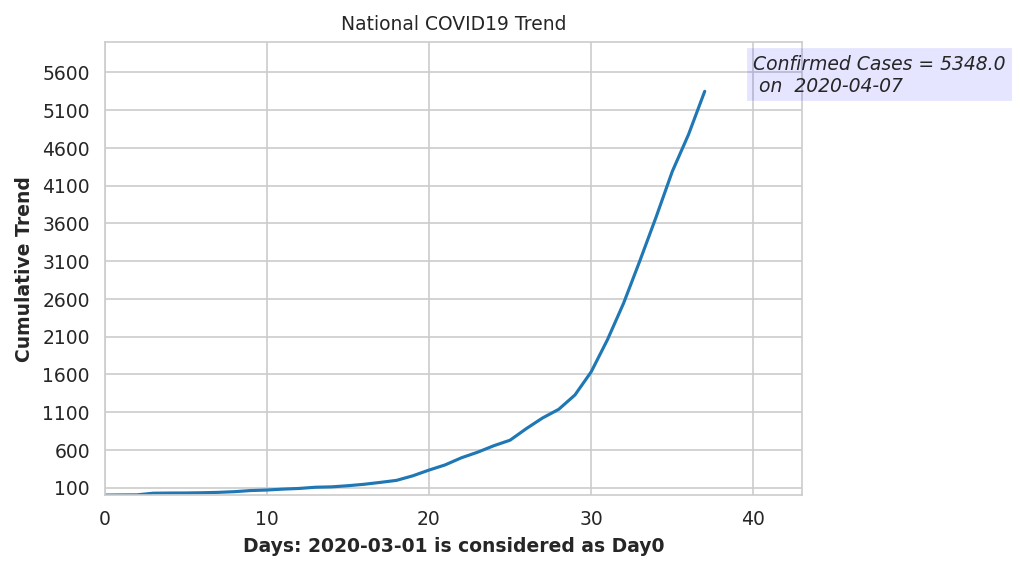

In [31]:
max_cases=6000
xloc=40

trainn=final_data.copy()
States=list(trainn.State.unique())
confcase=np.zeros((tot_days,len(States)))
for j in range (0,len(States)):
    tt= trainn.query('State == '+ '"'+States[j]+'"')
    confcase[:,j]=tt.ConfirmedCases
tot_cases=confcase.sum(axis=1)
plt.plot(np.arange(0,tot_days),confcase.sum(axis=1))
plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
plt.ylabel('Cumulative Trend')
plt.xticks(np.arange(0,tot_days+5,10))
plt.xlim([0,tot_days+5]);plt.ylim([0,max_cases])
plt.yticks(np.arange(100,max_cases,500))
plt.text(xloc, tot_cases[-1], 'Confirmed Cases' +" = "+ str(tot_cases[-1])+ '\n on  ' + str(till_date), style='italic',bbox={'facecolor':'blue', 'alpha': 0.1, 'pad': 3})
plt.title('National COVID19 Trend')

# Visualization of State-wise trends
 **Plot the trends of Highly affected states till date**
##Linear Trend

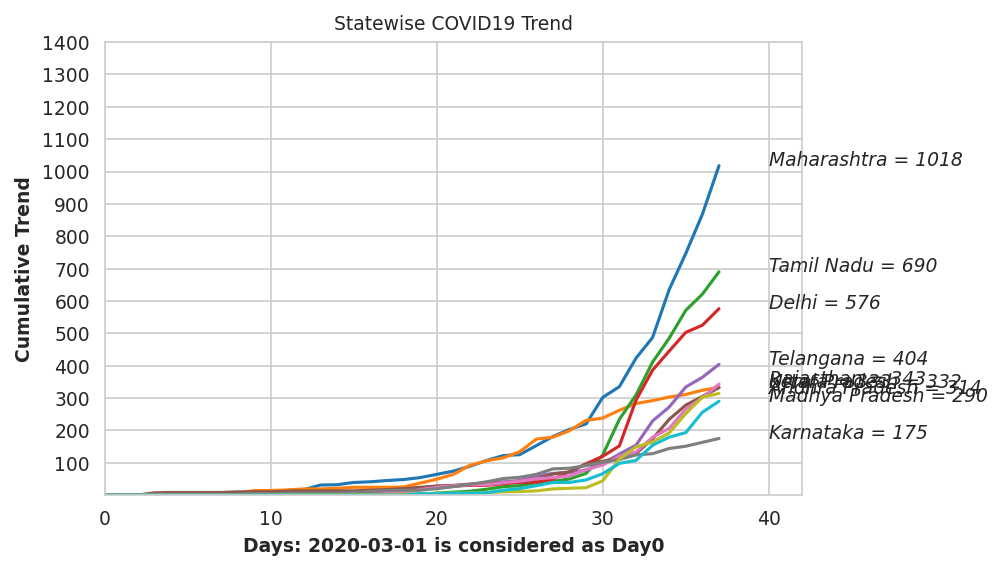

In [94]:
no_states=10           #provide the no. of highest infected (Descending order)
max_cases=1500
xloc=40

trains=final_data
States=list(trains.State.unique())
gb=pd.DataFrame(trains.groupby(['State'])['ConfirmedCases'].agg('sum'))
stsort=gb.sort_values(by=['ConfirmedCases'],ascending=False)

for j in range (0,no_states):
    tt= trains.query('State == '+ '"'+stsort.index[j]+'"')
    tss=tt.ConfirmedCases
    days=(tt.Day)
    plt.plot(days,(tss))
#    plt.legend()
    plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
    plt.ylabel('Cumulative Trend')
    plt.xticks(np.arange(0,tot_days+5,10))
    plt.xlim([0,tot_days+5]);plt.ylim([0,1200])
    plt.yticks(np.arange(100,max_cases,100))
    plt.text(xloc, tss.iloc[-1], str(stsort.index[j]) +" = "+ str(tss.iloc[-1]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
    plt.title('Statewise COVID19 Trend')


# Logarithmic Trend

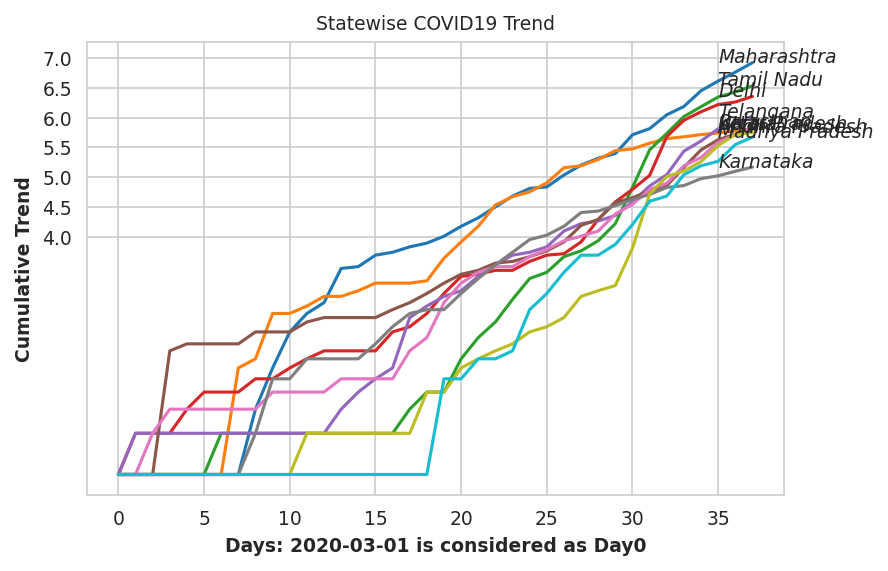

In [18]:
for j in range (0,no_states):
    tt= trains.query('State == '+ '"'+stsort.index[j]+'"')
    tss=tt.ConfirmedCases
    #a=tt['Confirmed'].cumsum()
    days=(tt.Day)
    plt.plot(days,np.log(tss+1))
#    plt.legend()
    plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
    plt.ylabel('Cumulative Trend')
    plt.xticks(days[::5])
    plt.yticks(np.arange(4,7.5,.5))
    plt.text(35, np.log(tss.max()), str(stsort.index[j]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
    plt.title('Statewise COVID19 Trend')

# **Compare the trends of selected states**
**Pls copy the state name from the following list**

['Kerala', 'Delhi', 'Telangana', 'Rajasthan', 'Haryana', 'Uttar Pradesh', 'Ladakh', 'Tamil Nadu', 'Jammu and Kashmir', 'Karnataka', 'Maharashtra', 'Punjab', 'Andhra Pradesh', 'Uttarakhand', 'Odisha', 'Puducherry', 'West Bengal', 'Chandigarh', 'Chhattisgarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh', 'Bihar', 'Manipur', 'Mizoram', 'Goa', 'Andaman and Nicobar Islands', 'Jharkhand', 'Assam', 'Arunachal Pradesh', 'Dadra and Nagar Haveli', 'Tripura']

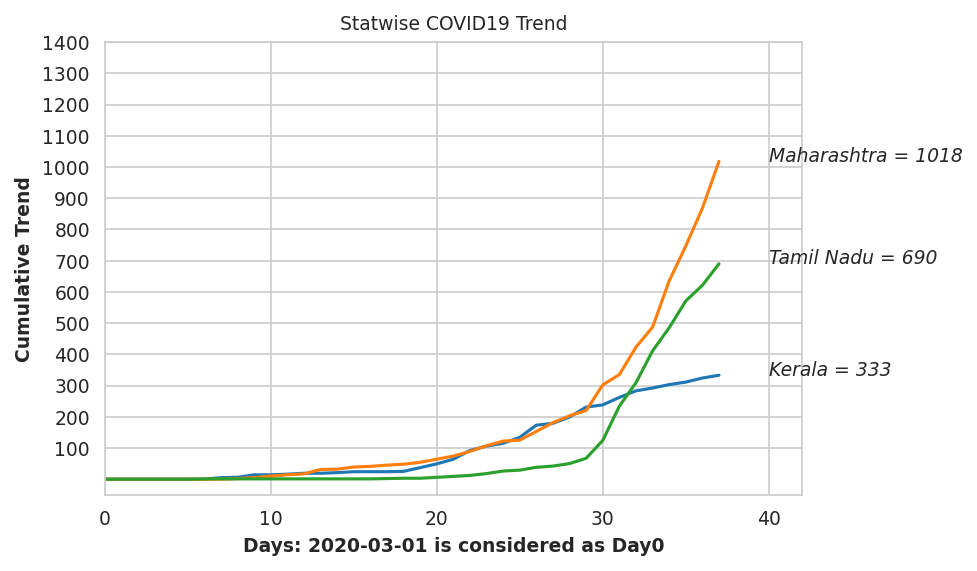

In [95]:
state_name=['Kerala', 'Maharashtra', 'Tamil Nadu']
max_cases=1500
xloc=40

for j in range(0,len(state_name)):
  tt= trains.query('State == '+ '"'+state_name[j]+'"')
  tss=tt.ConfirmedCases
  days=(tt.Day)
  plt.plot(days,(tss))
  # plt.legend()
  plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
  plt.ylabel('Cumulative Trend')
  plt.xticks(np.arange(0,tot_days+5,10));plt.xlim([0,tot_days+5])
  plt.yticks(np.arange(100,max_cases,100))
  plt.text(xloc, tss.iloc[-1], str(state_name[j]) +" = "+ str(tss.iloc[-1]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
  plt.title('Statwise COVID19 Trend')


# Visualization of Districtwise trends
 **Plot the trends of Highly affected states till date**
##Linear Trend

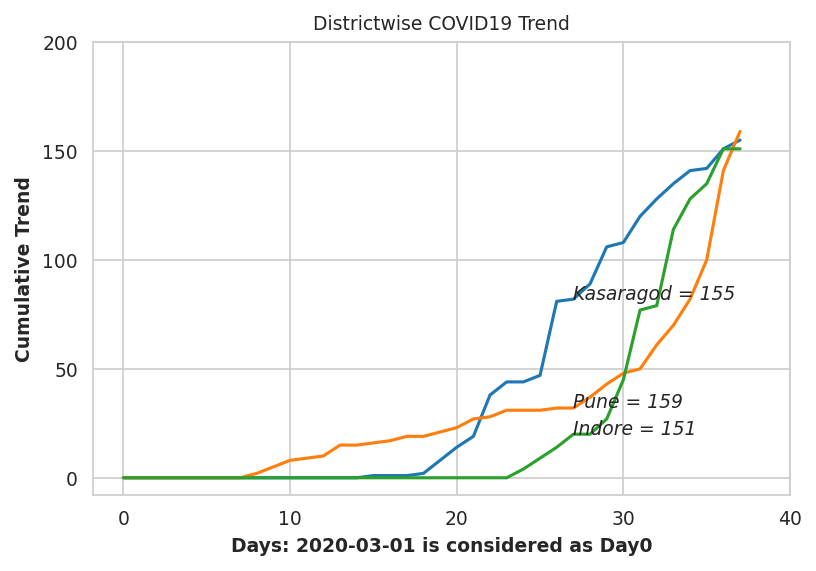

In [102]:
no_districts=5         #provide the no. of highest infected (Descending order)
max_cases=200; step=50
             # location of label in x axis (day?)

traind=final_datad
Districts=list(traind.District.unique())
gb=pd.DataFrame(traind.groupby(['District'])['ConfirmedCases'].agg('sum'))
stsort=gb.sort_values(by=['ConfirmedCases'],ascending=False)

for j in range (2,no_districts):
    tt= traind.query('District == '+ '"'+stsort.index[j]+'"')
    tss=tt.ConfirmedCases
    days=(tt.Day)
    plt.plot(days,(tss))
#    plt.legend()
    plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
    plt.ylabel('Cumulative Trend')
    plt.xticks(np.arange(0,tot_days+5,10))
    plt.yticks(np.arange(0,max_cases+1,step))
    plt.text(tot_days-10, tss.iloc[tot_days-10], str(stsort.index[j]) +" = "+ str(tss.iloc[-1]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
    # plt.text(30, tss.iloc[35], str(tss.iloc[35]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
    plt.title('Districtwise COVID19 Trend')

# **Compare the trends of selected Districts**
**Pls copy the district name from the following list** (in Chronological order)

['Thrissur', 'Alappuzha', 'Kasaragod', 'East Delhi', 'Hyderabad', 'Italians', 'Agra', 'South West Delhi', 'Ghaziabad', 'West Delhi', 'Leh', 'Kancheepuram', 'Pathanamthitta', 'North Delhi', 'Jammu', 'Bengaluru', 'Kannur', 'Pune', 'Amritsar', 'Ernakulam', 'Kottayam', 'Jaipur', 'Mumbai', 'S.P.S. Nellore', 'Kalaburagi', 'Nagpur', 'Thane', 'Lucknow', 'New Delhi', 'Thiruvananthapuram', 'Ahmadnagar', 'Yavatmal', 'Idukki', 'Aurangabad', 'Dehradun', 'Malappuram', 'Khordha', 'South Delhi', 'Gurugram', 'Kargil', 'Mahe', 'Gautam Buddha Nagar', 'Kolkata', 'Chennai', 'Ratnagiri', 'Srinagar', 'Jhunjhunu', 'North East Delhi', 'Chandigarh', 'Kodagu', 'Prakasam', 'Raipur', 'Kheri', 'Shahid Bhagat Singh Nagar', 'Rajkot', 'Surat', 'Visakhapatnam', 'North West Delhi', 'S.A.S. Nagar', 'Ahmadabad', 'Vadodara', 'Bhilwara', 'Faridabad', 'Panipat', 'Kangra', 'Jabalpur', 'Karimnagar', '', 'North 24 Parganas', 'Chikkaballapura', 'Panchkula', 'Gandhinagar', 'Moradabad', 'Erode', 'Hoshiarpur', 'Mysuru', 'Sonipat', 'Kachchh', 'East Godavari', 'Krishna', 'Varanasi', 'Dharwad', 'Coimbatore', 'Munger', 'Patna', 'Bhopal', 'Bhadradri Kothagudem', 'Uttara Kannada', 'Kozhikode', 'Tirunelveli', 'Jodhpur', 'Pali', 'Sikar', 'Palwal', 'Sangli', 'Satara', 'Kanpur Nagar', 'Pilibhit', 'Pratapgarh', 'Tiruppur', 'Madurai', 'Jaunpur', 'Imphal West', 'Dakshina Kannada', 'Ranga Reddy', 'Bandipore', 'Jalandhar', 'Palakkad', 'Chittoor', 'Indore', 'Ujjain', 'Gwalior', 'Aizawl', 'Salem', 'Udupi', 'Shivpuri', 'Chitradurga', 'Ludhiana', 'Pauri Garhwal', 'Rajnandgaon', 'Vellore', 'Guntur', 'North Goa', 'Bilaspur', 'Durg', 'Baghpat', 'South Andaman', 'Medchal Malkajgiri', 'Tiruchirappalli', 'Wayanad', 'Rajouri', 'Sindhudurg', 'North and Middle Andaman', 'Siwan', 'Nalanda', 'Gondiya', 'Tumakuru', 'Kollam', 'Kolhapur', 'Gujarat*', 'Shamli', 'Davanagere', 'Nadia', 'Dungarpur', 'Churu', 'Chengalpattu', 'Mahesana', 'Thanjavur', 'Ajmer', 'Virudhunagar', 'Medinipur East', 'Bhavnagar', 'Meerut', 'Jalgaon', 'Kurnool', 'Kalimpong', 'Lakhisarai', 'Ambala', 'Badgam', 'Baramula', 'Buldana', 'Porbandar', 'Gir Somnath', 'Bareilly', 'Hooghly', 'Nashik', 'Evacuees', 'Karur', 'Shupiyan', 'Bulandshahr', 'Ballari', 'Alwar', 'Korba', 'Gopalganj', 'Howrah', 'South 24 Parganas', 'Tiruvannamalai', 'Viluppuram', 'Anantapur', 'Ranchi', 'Sirsa', 'Cachar', 'Hisar', 'Namakkal', 'Kanniyakumari', 'Thoothukkudi', 'Gaya', 'Bhadrak', 'Puducherry', 'West Godavari', 'Y.S.R.', 'Begusarai', 'Kamrup Metropolitan', 'Basti', 'Theni', 'Dindigul', 'Sivaganga', 'Tirupathur', 'Thiruvarur', 'Panch Mahals', 'Jorhat', 'Tonk', 'Goalpara', 'Lohit', 'Dhaulpur', 'Udaipur', 'Rohtak', 'Bidar', 'Bharatpur', 'Ranipet', 'Ramanathapuram', 'Thiruvallur', 'Hazaribagh', 'Chhindwara', 'Saran', 'Osmanabad', 'Una', 'Udham Singh Nagar', 'Bikaner', 'Bagalkote', 'Hardoi', 'Shahjahanpur', 'Firozabad', 'Azamgarh', 'Saharanpur', 'Hapur', 'Nuh', 'Cuttack', 'Dausa', 'Nagapattinam', 'Nalbari', 'South Salmara Mancachar', 'Patiala', 'Morena', 'Belagavi', 'Karnal', 'Washim', 'Hingoli', 'Puri', 'Jajapur', 'Ghazipur', 'Kamrup', 'Morigaon', 'Golaghat', 'Banswara', 'Udhampur', 'Amravati', 'Patan', 'Rupnagar', 'Mansa', 'Lakhimpur', 'Bhiwani', 'Kaithal', 'Bengaluru Rural', 'Banda', 'Mahrajganj', 'Nainital', 'Haridwar', 'Cuddalore', 'Kallakurichi', 'Perambalur', 'Pathankot', 'Faridkot', 'Bhagalpur', 'Hathras', 'Hatras', 'Mirzapur', 'Khargone', 'Kalahandi', 'Latur', 'Karauli', 'Chota Udaipur', 'Bokaro', 'Barnala', 'The Nilgiris', 'Jalna', 'Nagaur', 'Barwani', 'Rae Bareli', 'Bara Banki', 'Auraiya', 'Warangal Urban', 'Vikarabad', 'Adilabad', 'Nirmal', 'Nizamabad', 'Peddapalli', 'Sangareddy', 'Jamnagar', 'Morbi', 'Jaisalmer', 'Kota', 'Almora', 'Kaushambi', 'Bijnor', 'Prayagraj', 'Sitapur', 'Ariyalur', 'Charki Dadri', 'Fatehgarh Sahib', 'Kapurthala', 'Betul', 'Vidisha', 'Kendrapara', 'Gomati']

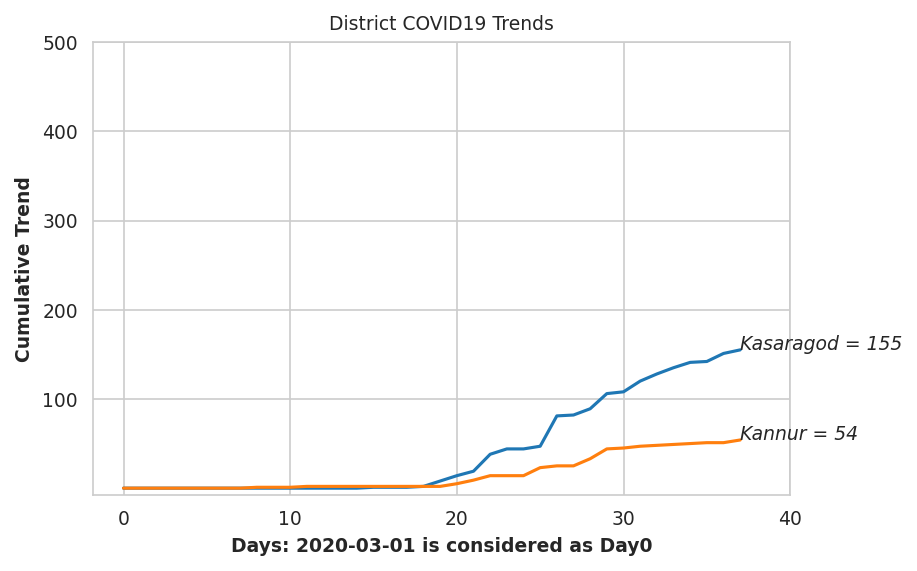

In [103]:
district_name=['Kasaragod', 'Kannur']
max_cases=600


for j in range(0,len(district_name)):
  tt= traind.query('District == '+ '"'+district_name[j]+'"')
  tss=tt.ConfirmedCases
  days=(tt.Day)
  plt.plot(days,(tss))
  # plt.legend()
  plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
  plt.ylabel('Cumulative Trend')
  plt.xticks([0,10,20,30,40])
  plt.yticks(np.arange(100,max_cases,100))
  plt.text(tot_days, tss.iloc[-1], district_name[j] +" = "+ str(tss.iloc[-1]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
  plt.title('District COVID19 Trends')



#**Infected population based on Age (Male/Female)**

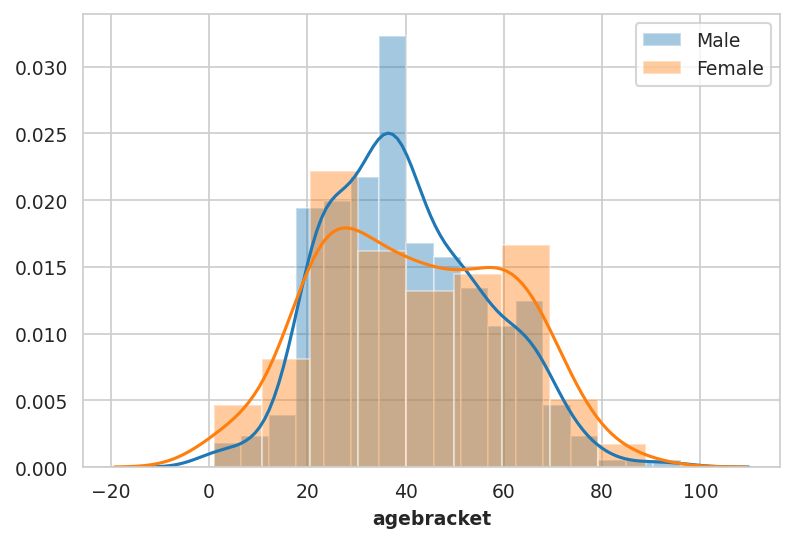

In [24]:
# gb=pd.to_numeric(data_temp.loc[:,'agebracket'], errors='coerce')
# sb.kdeplot(gb, shade=True,label='Age');

# plt.figure()
# sb.distplot(gb, hist=True, rug=True, label='Age',title=);

md=data_temp.query('gender == "M"')
mdg=pd.to_numeric(md.loc[:,'agebracket'], errors='coerce')
fd=data_temp.query('gender == "F"')
fdg=pd.to_numeric(fd.loc[:,'agebracket'], errors='coerce')
sb.distplot(mdg,hist=True,label='Male');
sb.distplot(fdg,hist=True,label='Female');
plt.legend();

#**Pie Chart of Imported, TBD (uncertain) and Local Cases**

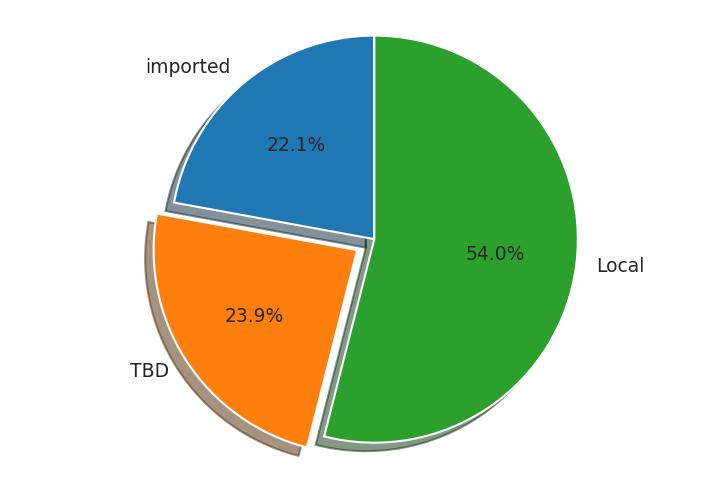

In [25]:
fd=data_temp.query('typeoftransmission == "Imported"')
imp=fd.loc[:,'typeoftransmission'].count()
fd=data_temp.query('typeoftransmission == "TBD"')
tbd=fd.loc[:,'typeoftransmission'].count()
fd=data_temp.query('typeoftransmission == "Local"')
local=fd.loc[:,'typeoftransmission'].count()
tt=np.array([imp,tbd,local])
labels = 'imported', 'TBD', 'Local'
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(tt, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#**Pie Chart of Imported, TBD (uncertain) and Local Cases State-wise**

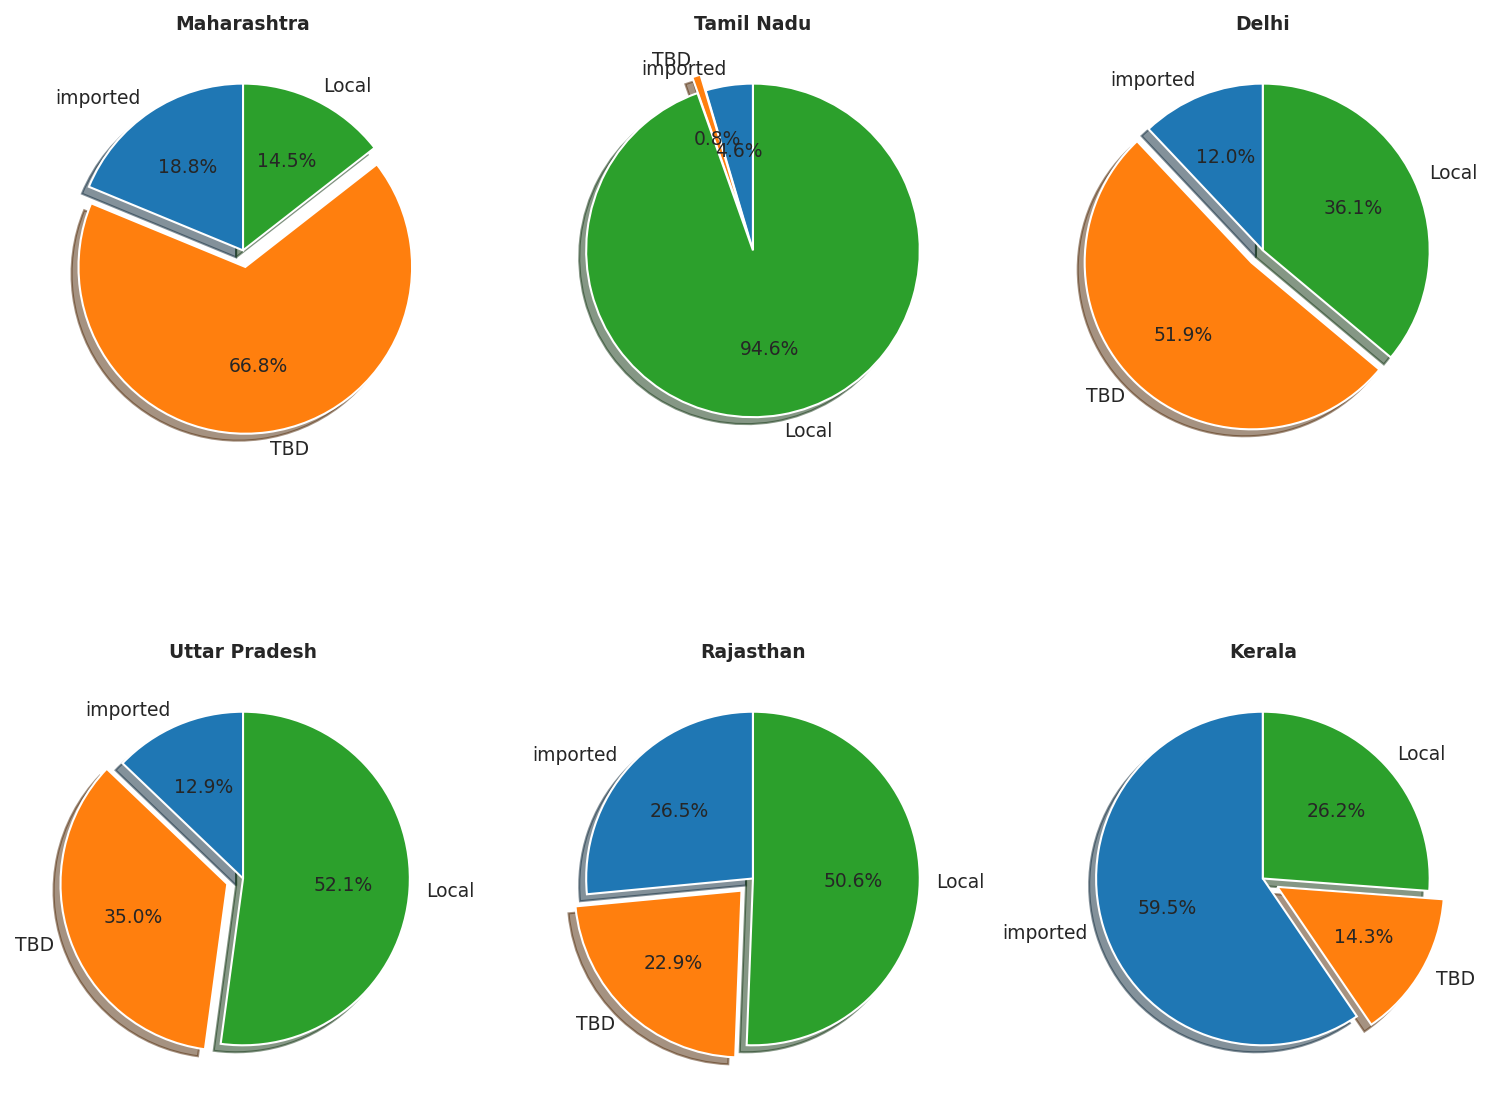

In [82]:
state=list(['Maharashtra', 'Tamil Nadu', 'Delhi', 'Uttar Pradesh', 'Rajasthan', 'Kerala'])
labels = 'imported', 'TBD', 'Local'
explode = (0, 0.1, 0) 
fig1, ax1 = plt.subplots(2,3, figsize=(10, 12), sharey=True)
count=0
for i in range(0, 2):
  for j in range(0,int(len(state)/2),1):
    fdd=data_temp.query('detectedstate == "'+str(state[count])+'"')
    fd=fdd.query('typeoftransmission == "Imported"')
    imp=fd.loc[:,'typeoftransmission'].count()
    fd=fdd.query('typeoftransmission == "TBD"')
    tbd=fd.loc[:,'typeoftransmission'].count()
    fd=fdd.query('typeoftransmission == "Local"')
    local=fd.loc[:,'typeoftransmission'].count()
    tt=np.array([imp,tbd,local])
    patches, texts, autotexts=ax1[i,j].pie(tt, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    # ax1[i,j].axis('equal') 
    ax1[i,j].set_title(str(state[count]),fontweight='bold')
    # plt.setp(autotexts, size='x-small')
    count=count+1
    plt.tight_layout()

#**Pie Chart of Imported, TBD (uncertain) and Local Cases District-wise**

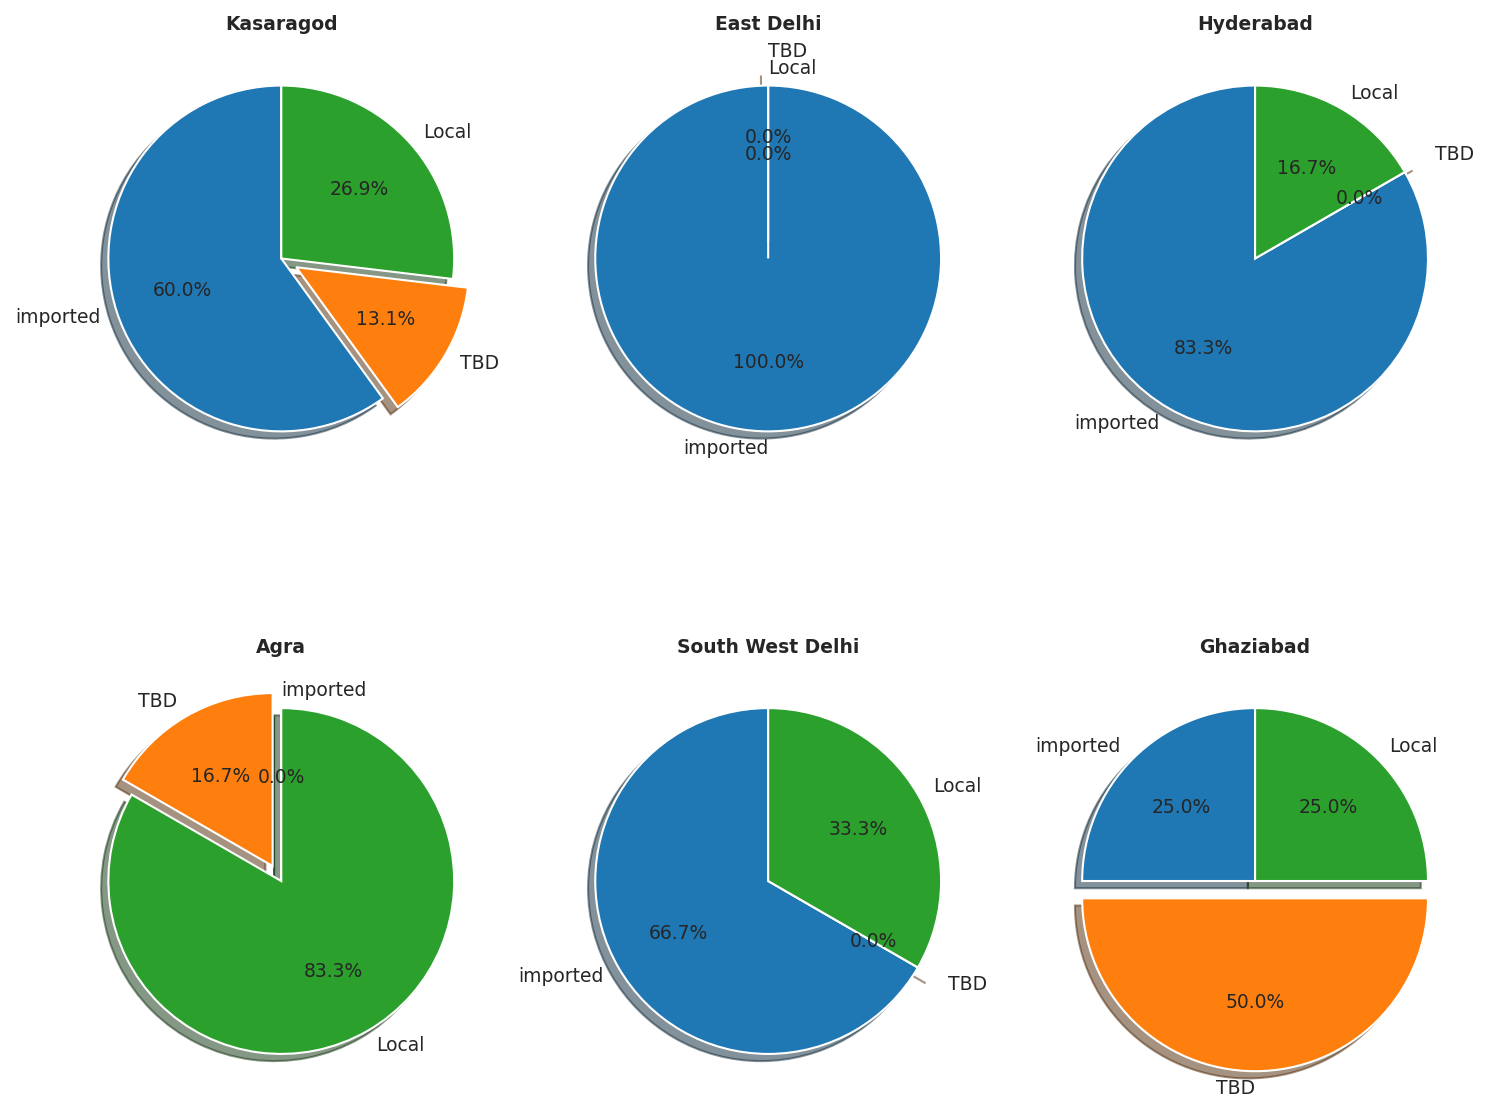

In [14]:
district=list(['Kasaragod', 'East Delhi', 'Hyderabad', 'Agra', 'South West Delhi', 'Ghaziabad'])
labels = 'imported', 'TBD', 'Local'
explode = (0, 0.1, 0) 
fig1, ax1 = plt.subplots(2,3, figsize=(10, 12), sharey=True)
count=0
for i in range(0, 2):
  for j in range(0,int(len(district)/2),1):
    fdd=data_temp.query('detecteddistrict == "'+str(district[count])+'"')
    fd=fdd.query('typeoftransmission == "Imported"')
    imp=fd.loc[:,'typeoftransmission'].count()
    fd=fdd.query('typeoftransmission == "TBD"')
    tbd=fd.loc[:,'typeoftransmission'].count()
    fd=fdd.query('typeoftransmission == "Local"')
    local=fd.loc[:,'typeoftransmission'].count()
    tt=np.array([imp,tbd,local])
    patches, texts, autotexts=ax1[i,j].pie(tt, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    # ax1[i,j].axis('equal') 
    ax1[i,j].set_title(str(district[count]),fontweight='bold')
    # plt.setp(autotexts, size='x-small')
    count=count+1
    plt.tight_layout()

# **Imported transmission by Males based on Age**

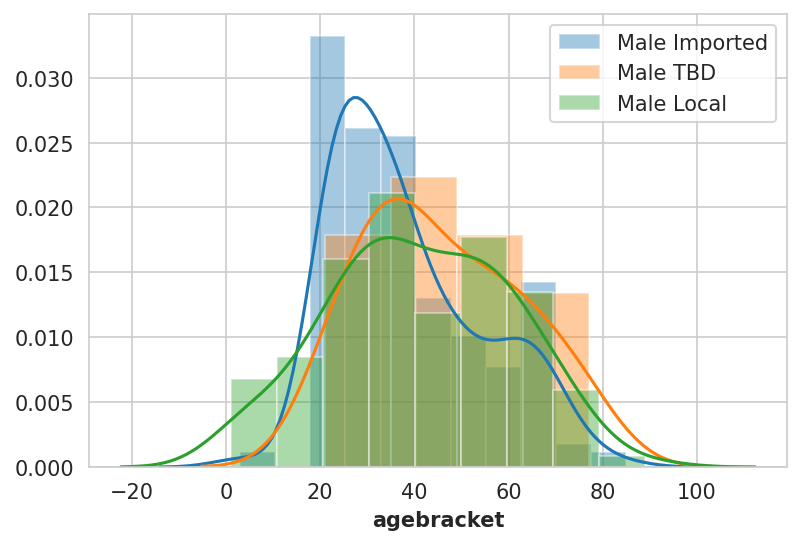

In [379]:
fdd=data_temp.query('typeoftransmission == "Imported"')
# imp=fd.loc[:,'typeoftransmission'].count()
md=fdd.query('gender == "M"')
mdg=pd.to_numeric(md.loc[:,'agebracket'], errors='coerce')
sb.distplot(mdg,hist=True,label='Male Imported');

fdd=data_temp.query('typeoftransmission == "TBD"')
# imp=fd.loc[:,'typeoftransmission'].count()
md=fdd.query('gender == "M"')
mdg=pd.to_numeric(md.loc[:,'agebracket'], errors='coerce')
sb.distplot(mdg,hist=True,label='Male TBD');

fdd=data_temp.query('typeoftransmission == "Local"')
# imp=fd.loc[:,'typeoftransmission'].count()
md=fdd.query('gender == "M"')
mdg=pd.to_numeric(md.loc[:,'agebracket'], errors='coerce')
sb.distplot(fdg,hist=True,label='Male Local');
plt.legend();

# **Imported transmission by Females based on Age**

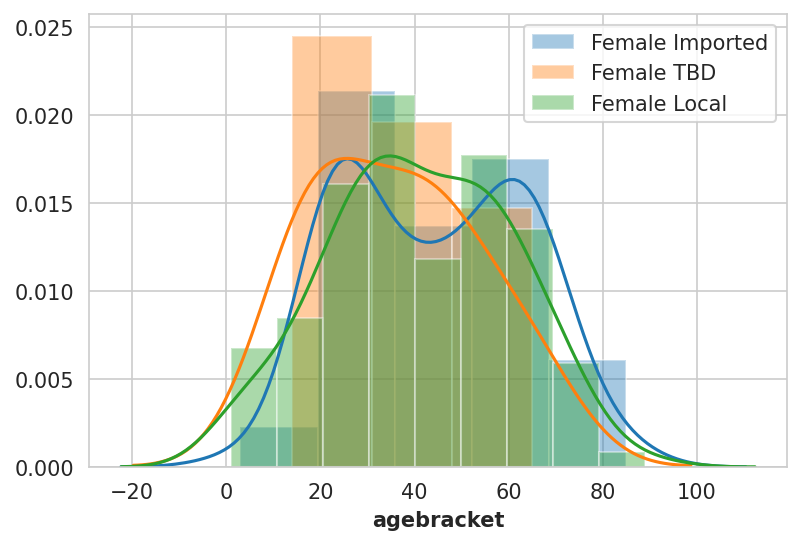

In [380]:
fdd=data_temp.query('typeoftransmission == "Imported"')
# imp=fd.loc[:,'typeoftransmission'].count()
md=fdd.query('gender == "F"')
mdg=pd.to_numeric(md.loc[:,'agebracket'], errors='coerce')
sb.distplot(mdg,hist=True,label='Female Imported');

fdd=data_temp.query('typeoftransmission == "TBD"')
# imp=fd.loc[:,'typeoftransmission'].count()
md=fdd.query('gender == "F"')
mdg=pd.to_numeric(md.loc[:,'agebracket'], errors='coerce')
sb.distplot(mdg,hist=True,label='Female TBD');

fdd=data_temp.query('typeoftransmission == "Local"')
# imp=fd.loc[:,'typeoftransmission'].count()
md=fdd.query('gender == "F"')
mdg=pd.to_numeric(md.loc[:,'agebracket'], errors='coerce')
sb.distplot(fdg,hist=True,label='Female Local');
plt.legend();